# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

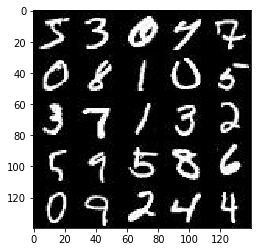

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

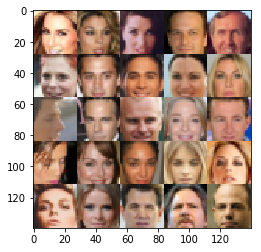

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", line 177, in s

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # print(batch_images.shape) # <- (128, 28, 28, 1) for MNIST
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5
                #  of 28x28 dimensional images.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) saw suggestion to run 2x
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
        # show images at end of training
        #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4281 ... Generator Loss: 5.8225
Epoch 1/2... Discriminator Loss: 0.4206 ... Generator Loss: 4.3472
Epoch 1/2... Discriminator Loss: 0.3682 ... Generator Loss: 5.1219
Epoch 1/2... Discriminator Loss: 0.4952 ... Generator Loss: 2.0543
Epoch 1/2... Discriminator Loss: 0.3604 ... Generator Loss: 5.2938
Epoch 1/2... Discriminator Loss: 0.3338 ... Generator Loss: 7.2525
Epoch 1/2... Discriminator Loss: 3.7055 ... Generator Loss: 0.0722
Epoch 1/2... Discriminator Loss: 0.6917 ... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 1.1251 ... Generator Loss: 4.8902
Epoch 1/2... Discriminator Loss: 0.9783 ... Generator Loss: 1.3415


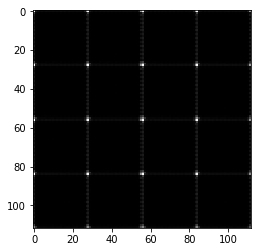

Epoch 1/2... Discriminator Loss: 2.0219 ... Generator Loss: 0.2889
Epoch 1/2... Discriminator Loss: 1.4972 ... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.8387 ... Generator Loss: 0.3320
Epoch 1/2... Discriminator Loss: 1.3497 ... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.6424 ... Generator Loss: 0.4072
Epoch 1/2... Discriminator Loss: 1.0260 ... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.3156 ... Generator Loss: 1.3347
Epoch 1/2... Discriminator Loss: 1.3104 ... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 1.1871 ... Generator Loss: 1.0889
Epoch 1/2... Discriminator Loss: 1.1103 ... Generator Loss: 1.6295


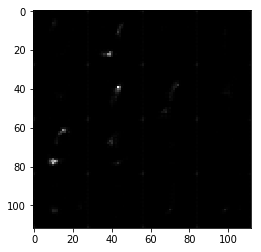

Epoch 1/2... Discriminator Loss: 1.2349 ... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 1.2332 ... Generator Loss: 1.1936
Epoch 1/2... Discriminator Loss: 1.2351 ... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 1.2705 ... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.1480 ... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.3318 ... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.5673 ... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.2999 ... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 1.5435 ... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.1189 ... Generator Loss: 0.8463


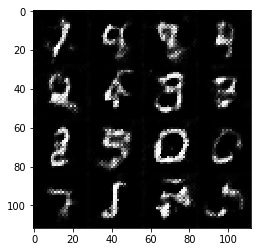

Epoch 1/2... Discriminator Loss: 1.1034 ... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.2875 ... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.4345 ... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.5081 ... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 0.7982 ... Generator Loss: 1.8710
Epoch 1/2... Discriminator Loss: 1.1608 ... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.0022 ... Generator Loss: 1.9871
Epoch 1/2... Discriminator Loss: 1.0447 ... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.0255 ... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.1471 ... Generator Loss: 1.8586


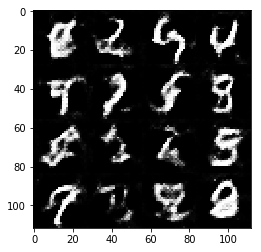

Epoch 1/2... Discriminator Loss: 1.4482 ... Generator Loss: 1.8228
Epoch 1/2... Discriminator Loss: 0.8401 ... Generator Loss: 2.1079
Epoch 1/2... Discriminator Loss: 1.0978 ... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.6080 ... Generator Loss: 0.3760
Epoch 1/2... Discriminator Loss: 0.9387 ... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 1.4274 ... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 0.8628 ... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 0.8796 ... Generator Loss: 2.2759
Epoch 1/2... Discriminator Loss: 1.1185 ... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.2192 ... Generator Loss: 0.6444


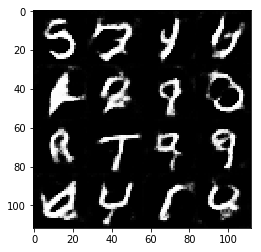

Epoch 1/2... Discriminator Loss: 1.1393 ... Generator Loss: 2.8764
Epoch 1/2... Discriminator Loss: 1.0247 ... Generator Loss: 1.8032
Epoch 1/2... Discriminator Loss: 0.7401 ... Generator Loss: 2.1265
Epoch 1/2... Discriminator Loss: 1.2319 ... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 0.6665 ... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 2.1284 ... Generator Loss: 0.2644
Epoch 1/2... Discriminator Loss: 1.2652 ... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 0.7522 ... Generator Loss: 1.8512
Epoch 1/2... Discriminator Loss: 1.7222 ... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 0.5942 ... Generator Loss: 1.7981


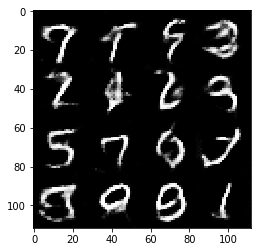

Epoch 1/2... Discriminator Loss: 1.2636 ... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 0.8055 ... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 0.6662 ... Generator Loss: 2.7916
Epoch 1/2... Discriminator Loss: 0.9448 ... Generator Loss: 2.0818
Epoch 1/2... Discriminator Loss: 0.9123 ... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.5840 ... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 0.8987 ... Generator Loss: 2.3387
Epoch 1/2... Discriminator Loss: 1.0104 ... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.8727 ... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.8927 ... Generator Loss: 1.4749


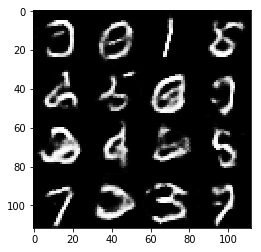

Epoch 1/2... Discriminator Loss: 0.9718 ... Generator Loss: 2.3247
Epoch 1/2... Discriminator Loss: 1.2878 ... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.2578 ... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 0.9671 ... Generator Loss: 1.2237
Epoch 1/2... Discriminator Loss: 0.8622 ... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.0570 ... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 0.9032 ... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 1.1349 ... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.0856 ... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 1.1264 ... Generator Loss: 0.7830


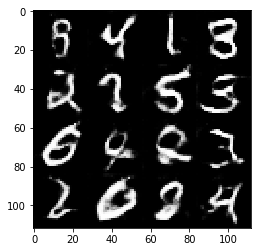

Epoch 1/2... Discriminator Loss: 1.2495 ... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 0.9107 ... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.2103 ... Generator Loss: 1.7908
Epoch 1/2... Discriminator Loss: 0.8696 ... Generator Loss: 1.7578
Epoch 1/2... Discriminator Loss: 1.1288 ... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.7604 ... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 1.1943 ... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.2127 ... Generator Loss: 1.3799
Epoch 1/2... Discriminator Loss: 1.1465 ... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.3147 ... Generator Loss: 0.5475


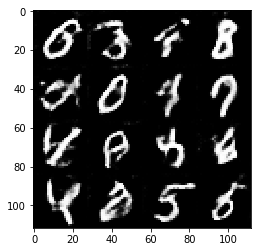

Epoch 1/2... Discriminator Loss: 1.8093 ... Generator Loss: 0.3033
Epoch 1/2... Discriminator Loss: 1.5758 ... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.2031 ... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.5362 ... Generator Loss: 0.4377
Epoch 2/2... Discriminator Loss: 1.1930 ... Generator Loss: 1.9293
Epoch 2/2... Discriminator Loss: 1.0763 ... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.1331 ... Generator Loss: 1.3174
Epoch 2/2... Discriminator Loss: 1.1675 ... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 1.9195 ... Generator Loss: 0.2711
Epoch 2/2... Discriminator Loss: 1.3122 ... Generator Loss: 0.7065


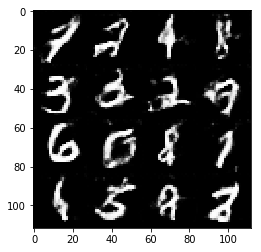

Epoch 2/2... Discriminator Loss: 1.3831 ... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 1.2758 ... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 1.2828 ... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.2396 ... Generator Loss: 1.3093
Epoch 2/2... Discriminator Loss: 0.9664 ... Generator Loss: 1.6072
Epoch 2/2... Discriminator Loss: 1.4457 ... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 1.8164 ... Generator Loss: 0.3083
Epoch 2/2... Discriminator Loss: 1.4810 ... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.1180 ... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.4884 ... Generator Loss: 0.4758


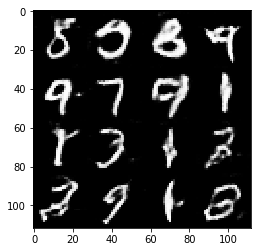

Epoch 2/2... Discriminator Loss: 1.1598 ... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.1196 ... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 0.9636 ... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 0.9042 ... Generator Loss: 1.6207
Epoch 2/2... Discriminator Loss: 0.9029 ... Generator Loss: 1.3708
Epoch 2/2... Discriminator Loss: 1.0835 ... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.9940 ... Generator Loss: 1.4665
Epoch 2/2... Discriminator Loss: 1.0187 ... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 1.2389 ... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 1.7314 ... Generator Loss: 0.3358


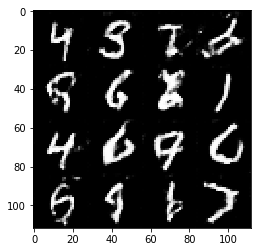

Epoch 2/2... Discriminator Loss: 1.1971 ... Generator Loss: 1.6504
Epoch 2/2... Discriminator Loss: 0.9916 ... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 0.9548 ... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 1.4108 ... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.1806 ... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 0.9507 ... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 1.0504 ... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 1.2098 ... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.2596 ... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1571 ... Generator Loss: 1.6153


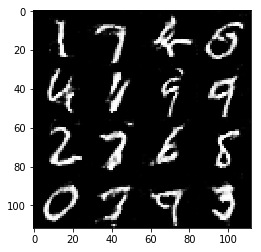

Epoch 2/2... Discriminator Loss: 1.0983 ... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 1.1877 ... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.1715 ... Generator Loss: 1.7015
Epoch 2/2... Discriminator Loss: 1.2495 ... Generator Loss: 1.3657
Epoch 2/2... Discriminator Loss: 1.5284 ... Generator Loss: 0.4378
Epoch 2/2... Discriminator Loss: 1.2014 ... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.1949 ... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 0.9721 ... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.2006 ... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.1258 ... Generator Loss: 0.8094


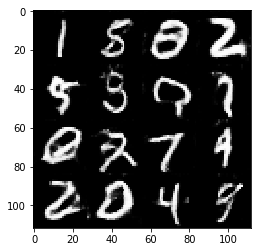

Epoch 2/2... Discriminator Loss: 1.3626 ... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.0305 ... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.6347 ... Generator Loss: 0.3793
Epoch 2/2... Discriminator Loss: 1.1800 ... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 1.1951 ... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.1325 ... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 0.9069 ... Generator Loss: 1.4662
Epoch 2/2... Discriminator Loss: 1.6332 ... Generator Loss: 0.3859
Epoch 2/2... Discriminator Loss: 1.3828 ... Generator Loss: 0.5365
Epoch 2/2... Discriminator Loss: 1.1019 ... Generator Loss: 1.6900


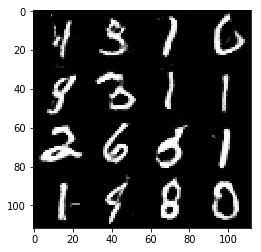

Epoch 2/2... Discriminator Loss: 1.0293 ... Generator Loss: 0.9452
Epoch 2/2... Discriminator Loss: 1.3768 ... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.2137 ... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.3342 ... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.6298 ... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 0.9502 ... Generator Loss: 1.1640
Epoch 2/2... Discriminator Loss: 0.9983 ... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 0.9774 ... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 1.8315 ... Generator Loss: 0.3292
Epoch 2/2... Discriminator Loss: 1.6019 ... Generator Loss: 0.4032


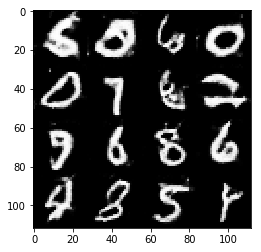

Epoch 2/2... Discriminator Loss: 1.0610 ... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 0.9581 ... Generator Loss: 1.2670
Epoch 2/2... Discriminator Loss: 1.1016 ... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.0478 ... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.2823 ... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 0.9705 ... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 0.8771 ... Generator Loss: 1.4312
Epoch 2/2... Discriminator Loss: 1.0664 ... Generator Loss: 1.7404
Epoch 2/2... Discriminator Loss: 1.2100 ... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.1991 ... Generator Loss: 0.6809


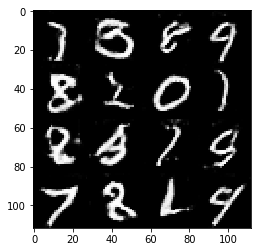

Epoch 2/2... Discriminator Loss: 1.6393 ... Generator Loss: 0.3720
Epoch 2/2... Discriminator Loss: 1.3757 ... Generator Loss: 0.5077
Epoch 2/2... Discriminator Loss: 1.3510 ... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.0244 ... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 1.2418 ... Generator Loss: 1.8901
Epoch 2/2... Discriminator Loss: 0.9702 ... Generator Loss: 1.1015
Epoch 2/2... Discriminator Loss: 0.9692 ... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 1.3553 ... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 0.7194 ... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 1.1956 ... Generator Loss: 1.0481


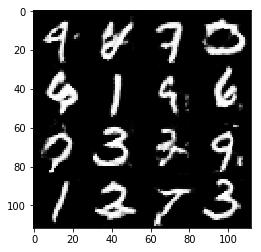

Epoch 2/2... Discriminator Loss: 1.1413 ... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.0571 ... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.1921 ... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.5997 ... Generator Loss: 0.3876
Epoch 2/2... Discriminator Loss: 1.1982 ... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.0551 ... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 0.9397 ... Generator Loss: 1.3342


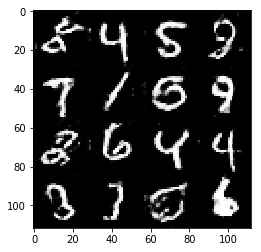

In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4443 ... Generator Loss: 3.0979
Epoch 1/1... Discriminator Loss: 0.3975 ... Generator Loss: 3.5498
Epoch 1/1... Discriminator Loss: 0.3955 ... Generator Loss: 3.7618
Epoch 1/1... Discriminator Loss: 0.6842 ... Generator Loss: 1.9604
Epoch 1/1... Discriminator Loss: 0.8023 ... Generator Loss: 8.1303
Epoch 1/1... Discriminator Loss: 1.4045 ... Generator Loss: 3.7076
Epoch 1/1... Discriminator Loss: 0.6667 ... Generator Loss: 2.8608
Epoch 1/1... Discriminator Loss: 0.8810 ... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.3364 ... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 0.7191 ... Generator Loss: 1.4283


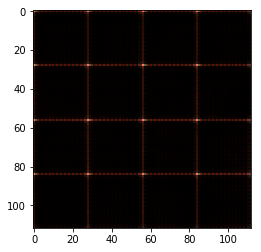

Epoch 1/1... Discriminator Loss: 0.5415 ... Generator Loss: 2.4569
Epoch 1/1... Discriminator Loss: 1.9114 ... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 0.4660 ... Generator Loss: 2.8533
Epoch 1/1... Discriminator Loss: 0.4521 ... Generator Loss: 2.6690
Epoch 1/1... Discriminator Loss: 1.2213 ... Generator Loss: 2.5733
Epoch 1/1... Discriminator Loss: 0.8269 ... Generator Loss: 3.2064
Epoch 1/1... Discriminator Loss: 1.9543 ... Generator Loss: 4.5164
Epoch 1/1... Discriminator Loss: 0.8971 ... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 1.9589 ... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.7776 ... Generator Loss: 0.3438


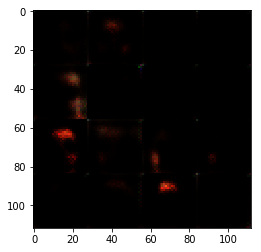

Epoch 1/1... Discriminator Loss: 1.4620 ... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.0477 ... Generator Loss: 2.3130
Epoch 1/1... Discriminator Loss: 0.9528 ... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.9236 ... Generator Loss: 2.9627
Epoch 1/1... Discriminator Loss: 0.8724 ... Generator Loss: 3.9196
Epoch 1/1... Discriminator Loss: 1.7475 ... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 1.1128 ... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5094 ... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 2.2418 ... Generator Loss: 0.1888
Epoch 1/1... Discriminator Loss: 1.0302 ... Generator Loss: 2.1694


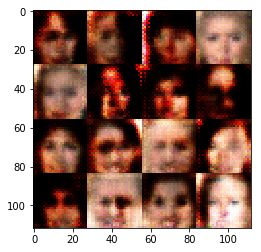

Epoch 1/1... Discriminator Loss: 0.8942 ... Generator Loss: 2.7959
Epoch 1/1... Discriminator Loss: 1.4159 ... Generator Loss: 1.9101
Epoch 1/1... Discriminator Loss: 0.8480 ... Generator Loss: 2.3003
Epoch 1/1... Discriminator Loss: 1.0209 ... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.5263 ... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 2.0034 ... Generator Loss: 3.1524
Epoch 1/1... Discriminator Loss: 0.8911 ... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.1706 ... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 1.1533 ... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 0.9254 ... Generator Loss: 2.1960


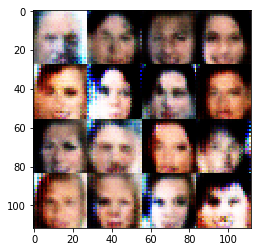

Epoch 1/1... Discriminator Loss: 1.5986 ... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: 1.1016 ... Generator Loss: 2.4611
Epoch 1/1... Discriminator Loss: 0.8660 ... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.0810 ... Generator Loss: 1.5509
Epoch 1/1... Discriminator Loss: 1.9855 ... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 0.9494 ... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.0439 ... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.5828 ... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.5521 ... Generator Loss: 2.0142
Epoch 1/1... Discriminator Loss: 1.0070 ... Generator Loss: 1.9331


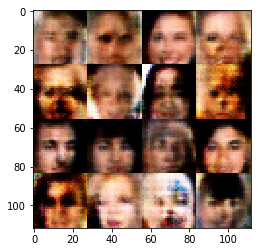

Epoch 1/1... Discriminator Loss: 0.8492 ... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.4564 ... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.4160 ... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.8870 ... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 0.8599 ... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.2405 ... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.7417 ... Generator Loss: 0.3150
Epoch 1/1... Discriminator Loss: 1.3445 ... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 1.2998 ... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.6612 ... Generator Loss: 1.5595


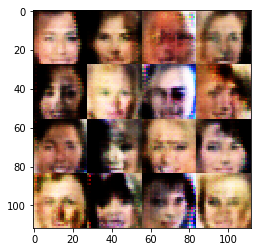

Epoch 1/1... Discriminator Loss: 1.2745 ... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.9632 ... Generator Loss: 1.9064
Epoch 1/1... Discriminator Loss: 1.2453 ... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.5821 ... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 1.0207 ... Generator Loss: 2.2864
Epoch 1/1... Discriminator Loss: 2.0076 ... Generator Loss: 0.2249
Epoch 1/1... Discriminator Loss: 1.3942 ... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.6847 ... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.9921 ... Generator Loss: 0.2306
Epoch 1/1... Discriminator Loss: 1.1098 ... Generator Loss: 1.0120


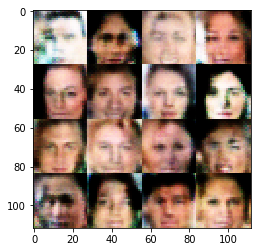

Epoch 1/1... Discriminator Loss: 0.9261 ... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.9756 ... Generator Loss: 2.5340
Epoch 1/1... Discriminator Loss: 1.0437 ... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.1295 ... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.5172 ... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.0050 ... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.0694 ... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 1.1387 ... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.8555 ... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.2325 ... Generator Loss: 2.2467


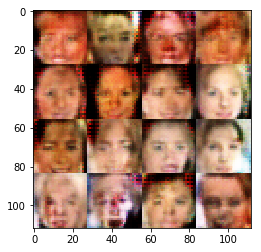

Epoch 1/1... Discriminator Loss: 1.2543 ... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4942 ... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.2516 ... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.7881 ... Generator Loss: 0.2990
Epoch 1/1... Discriminator Loss: 1.1605 ... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.6134 ... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.9197 ... Generator Loss: 0.2614
Epoch 1/1... Discriminator Loss: 1.7745 ... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 1.1880 ... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.1286 ... Generator Loss: 1.1155


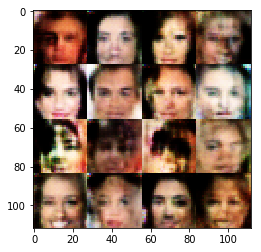

Epoch 1/1... Discriminator Loss: 1.3944 ... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 0.8320 ... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 0.9439 ... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 1.9556 ... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.9286 ... Generator Loss: 0.2510
Epoch 1/1... Discriminator Loss: 1.1976 ... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4352 ... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.8818 ... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.5240 ... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3803 ... Generator Loss: 1.6248


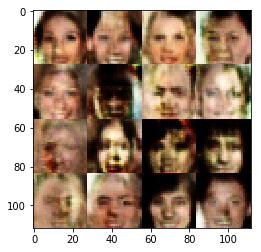

Epoch 1/1... Discriminator Loss: 0.8169 ... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.1723 ... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.9332 ... Generator Loss: 0.2571
Epoch 1/1... Discriminator Loss: 1.1406 ... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 0.7830 ... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.4689 ... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.9167 ... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 0.9637 ... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.5764 ... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.1006 ... Generator Loss: 0.8508


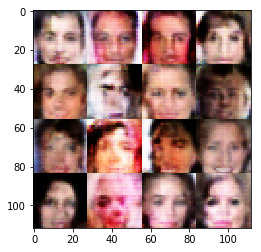

Epoch 1/1... Discriminator Loss: 1.2268 ... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.9932 ... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.2994 ... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2384 ... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.1504 ... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 1.2018 ... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.1401 ... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0789 ... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2889 ... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 0.5263 ... Generator Loss: 2.2772


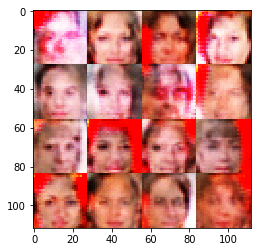

Epoch 1/1... Discriminator Loss: 0.6773 ... Generator Loss: 1.5004
Epoch 1/1... Discriminator Loss: 2.9472 ... Generator Loss: 0.1136
Epoch 1/1... Discriminator Loss: 1.6266 ... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 2.5969 ... Generator Loss: 2.3175
Epoch 1/1... Discriminator Loss: 1.4760 ... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.0790 ... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.7910 ... Generator Loss: 0.2923
Epoch 1/1... Discriminator Loss: 1.8749 ... Generator Loss: 0.2696
Epoch 1/1... Discriminator Loss: 1.0720 ... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 2.0110 ... Generator Loss: 0.2227


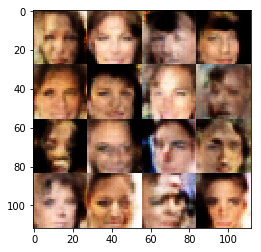

Epoch 1/1... Discriminator Loss: 1.1786 ... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5777 ... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.5331 ... Generator Loss: 2.3630
Epoch 1/1... Discriminator Loss: 0.9328 ... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 1.5772 ... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.0219 ... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4657 ... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.5938 ... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 2.0896 ... Generator Loss: 0.2081
Epoch 1/1... Discriminator Loss: 1.5120 ... Generator Loss: 0.4167


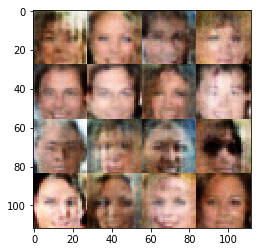

Epoch 1/1... Discriminator Loss: 1.4934 ... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.6202 ... Generator Loss: 0.3707
Epoch 1/1... Discriminator Loss: 1.2287 ... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.7325 ... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.5004 ... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.3920 ... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 1.9082 ... Generator Loss: 0.2548
Epoch 1/1... Discriminator Loss: 1.4597 ... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.1779 ... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.6414 ... Generator Loss: 0.3713


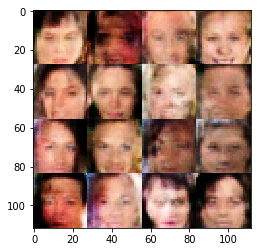

Epoch 1/1... Discriminator Loss: 1.1850 ... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 0.9031 ... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.3012 ... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.6236 ... Generator Loss: 2.1315
Epoch 1/1... Discriminator Loss: 1.7141 ... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.5722 ... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 0.5543 ... Generator Loss: 1.9219
Epoch 1/1... Discriminator Loss: 1.4095 ... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.2777 ... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.5631 ... Generator Loss: 1.6412


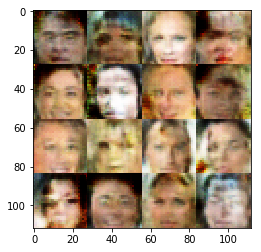

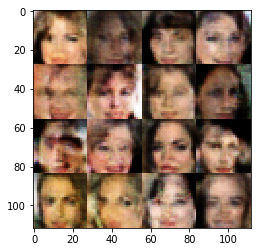

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.